In [ ]:
# ===== 0) Reset & Imports =====
# 환경 설정: tf_env 사용
import os
os.environ['CONDA_DEFAULT_ENV'] = 'tf_env'

import gc, numpy as np, pandas as pd, matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

In [2]:
# Python 환경 확인
import sys
print("Python 경로:", sys.executable)
print("Python 버전:", sys.version)

# 설치된 패키지 확인
try:
    import tensorflow as tf
    print("TensorFlow 버전:", tf.__version__)
except ImportError as e:
    print("TensorFlow 임포트 실패:", e)
    
# pip 경로 확인
import subprocess
result = subprocess.run([sys.executable, '-m', 'pip', 'list'], capture_output=True, text=True)
print("\n설치된 패키지 일부:")
for line in result.stdout.split('\n')[:10]:
    if 'tensor' in line.lower():
        print(line)

Python 경로: /opt/anaconda3/envs/tf_env/bin/python
Python 버전: 3.11.11 | packaged by conda-forge | (main, Dec  5 2024, 08:47:03) [Clang 18.1.8 ]
TensorFlow 버전: 2.18.0

설치된 패키지 일부:


In [3]:
# 완전 초기화
try: del model
except: pass
gc.collect()
keras.backend.clear_session()
np.random.seed(42); tf.random.set_seed(42)


In [ ]:
# ===== 1) Config =====
# Use the repo-local TFLite-ready CSV so feature names/order match mobile assets
DATA_PATH = "phishing/phishing_data_tflite_ready.csv"
TARGET = "status"
BATCH_SIZE, EPOCHS = 64, 50
# LABEL_MODE selects training target: 'soft' uses probability labels, 'binary' uses 0/1, 'both' keeps both and defaults to soft training
LABEL_MODE = 'both'  # options: 'soft' | 'binary' | 'both'
EARLY_STOP_AT_ACC = 0.95
# ===== 2) Load & Clean =====
df = pd.read_csv(DATA_PATH)
if "url" in df.columns: df = df.drop(columns=["url"])
df = shuffle(df, random_state=42)

In [ ]:
# 라벨 정리 (soft/binary 병행) — 마지막 컬럼 'status' 원본을 보존해서 소프트 라벨을 유지합니다.
# 1) 공통 문자열 매핑(대소문자 무시) -> 문자열 매핑을 numeric 문자열로 바꿔 놓음
df[TARGET] = df[TARGET].astype(str).str.strip().str.lower().replace({'legitimate': '0', 'phishing': '1'})
# 2) 텍스트 토큰 치환(혹시 남아있는 표현 처리)
df = df.replace({'zero': 0, 'one': 1, 'Zero': 0, 'One': 1})
# 3) 안전하게 숫자형으로 변환 후 float32로 캐스팅 — 이 값은 soft 라벨로 사용 가능
df['label_soft'] = pd.to_numeric(df[TARGET], errors="coerce").astype("float32")
# 4) label_soft의 범위를 검사하고 이상치(범위 밖)을 보고
print('label_soft min/max/mean:', df['label_soft'].min(), df['label_soft'].max(), df['label_soft'].mean())
# 5) hard binary label 생성 (앱/배포 호환성 용도)
df['label_binary'] = (df['label_soft'] >= 0.5).astype('float32')
print('Label counts (soft approx):', df['label_soft'].value_counts().head(10).to_dict())
print('Label counts (binary):', df['label_binary'].value_counts().to_dict())
# Note: we keep both label_soft and label_binary in the dataframe; training target selection controlled by LABEL_MODE

/var/folders/nv/tfw2zdqs7031dn83bb91bwdr0000gn/T/ipykernel_51029/3695572819.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[TARGET] = df[TARGET].astype(str).replace({"legitimate":0, "phishing":1})
/var/folders/nv/tfw2zdqs7031dn83bb91bwdr0000gn/T/ipykernel_51029/3695572819.py:6: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace({"zero":0,"one":1,"Zero":0,"One":1})


In [7]:
# ===== 3) 숫자 피처만 안전하게 선택 =====
feature_cols = [c for c in df.columns if c != TARGET]
numeric_cols = []
for c in feature_cols:
    ser = pd.to_numeric(df[c], errors="coerce")
    if ser.notna().any():           # 전부 NaN이 아니면 사용
        df[c] = ser
        numeric_cols.append(c)

assert len(numeric_cols) > 0, "사용 가능한 숫자 피처가 없습니다."

In [ ]:
# 결측치 중앙값으로 채우기
for c in numeric_cols:
    med = float(df[c].dropna().median()) if df[c].notna().any() else 0.0
    df[c] = df[c].fillna(med).astype("float32")

# ===== 4) 행렬(X, y)로 변환 =====
X = df[numeric_cols].to_numpy(dtype="float32")
# Prepare soft and binary targets — do not overwrite original soft values
y_soft = df['label_soft'].to_numpy(dtype="float32")
y_binary = df['label_binary'].to_numpy(dtype="float32")
# Choose training target based on LABEL_MODE (soft | binary | both). 'both' will train using soft by default
if LABEL_MODE == 'soft':
    y = y_soft
elif LABEL_MODE == 'binary':
    y = y_binary
else:  # 'both' default to soft for training but keep binary for evaluation/export
    y = y_soft


# Use index-based split so soft and binary targets align with the same train/validation indices
indices = np.arange(X.shape[0])
train_idx, val_idx = train_test_split(indices, test_size=0.2, stratify=y_binary, random_state=42)
X_train, X_val = X[train_idx], X[val_idx]
# aligned splits for both target types
y_soft_train, y_soft_val = y_soft[train_idx], y_soft[val_idx]
y_binary_train, y_binary_val = y_binary[train_idx], y_binary[val_idx]
if LABEL_MODE == 'soft':
    y_train, y_val = y_soft_train, y_soft_val
elif LABEL_MODE == 'binary':
    y_train, y_val = y_binary_train, y_binary_val
else:  # both - default to soft training, keep binary for evaluation
    y_train, y_val = y_soft_train, y_soft_val

print("X_train:", X_train.shape, " | X_val:", X_val.shape, " | n_features:", X_train.shape[1])

X_train: (9184, 87)  | X_val: (2297, 87)  | n_features: 87


In [16]:
# ===== 5) 모델 (단일 입력) =====
inp = keras.Input(shape=(X_train.shape[1],), name="features", dtype=tf.float32)
norm = layers.Normalization(name="norm_all")
norm.adapt(X_train)

x = norm(inp)
x = layers.Dense(64, activation="relu")(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(32, activation="relu")(x)
x = layers.Dropout(0.1)(x)
out = layers.Dense(1, activation="sigmoid")(x)

model = keras.Model(inputs=inp, outputs=out, name="phish_numeric_only")
model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=[keras.metrics.BinaryAccuracy(name="accuracy")]
)
model.summary()

Model: "phish_numeric_only"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ features (InputLayer)           │ (None, 87)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ norm_all (Normalization)        │ (None, 87)             │           175 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         5,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,920 (30.94 KB)

 Trainable params: 7,745 (30.25 KB)

 Non-trainable params: 175 (704.00 B)

In [ ]:
# ===== 6) 콜백 & 학습 =====
# class StopAtAcc(keras.callbacks.Callback):
#     def __init__(self, target=EARLY_STOP_AT_ACC): super().__init__(); self.target=target
#     def on_epoch_end(self, epoch, logs=None):
#         if logs and logs.get("accuracy",0) >= self.target:
#             print(f"\nReached {self.target*100:.0f}% accuracy — stopping.")
#             self.model.stop_training = True

# history = model.fit(
#     X_train, y_train,
#     validation_data=(X_val, y_val),
#     epochs=EPOCHS,
#     batch_size=BATCH_SIZE,
#     callbacks=[StopAtAcc()]
# )
es = keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=5, restore_best_weights=True
)

# Prepare sample weights when using soft labels: down-weight uncertain samples (near 0.5)
sample_weight = None
val_sample_weight = None
if LABEL_MODE == 'soft':
    sw = np.abs(y_train - 0.5) * 2.0  # maps distance to 0..1
    sw = np.clip(sw, 0.1, 1.0)  # floor to avoid zero weights
    sample_weight = sw
    vsw = np.abs(y_val - 0.5) * 2.0
    val_sample_weight = np.clip(vsw, 0.1, 1.0)
    print('Sample weight [train] min/max/mean:', sample_weight.min(), sample_weight.max(), sample_weight.mean())

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val, val_sample_weight) if val_sample_weight is not None else (X_val, y_val),
    epochs=EPOCHS, batch_size=BATCH_SIZE,
    callbacks=[es],
    sample_weight=sample_weight,
    verbose=1,
)

Epoch 1/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8344 - loss: 0.3833 - val_accuracy: 0.9303 - val_loss: 0.1842
Epoch 2/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8344 - loss: 0.3833 - val_accuracy: 0.9303 - val_loss: 0.1842
Epoch 2/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 655us/step - accuracy: 0.9414 - loss: 0.1591 - val_accuracy: 0.9465 - val_loss: 0.1400
Epoch 3/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 655us/step - accuracy: 0.9414 - loss: 0.1591 - val_accuracy: 0.9465 - val_loss: 0.1400
Epoch 3/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 653us/step - accuracy: 0.9526 - loss: 0.1330 - val_accuracy: 0.9525 - val_loss: 0.1264
Epoch 4/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 653us/step - accuracy: 0.9526 - loss: 0.1330 - val_accuracy: 0.9525 - val_loss: 0.1264
Epoch 4/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 663us/step - accuracy: 0.9583 - loss: 0.1153 - val_accuracy: 0.9560 - val_loss: 0.1187
Epoch 5/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 663us/step - accuracy: 0.9583 - loss: 0.1153 - val_

In [ ]:
# ===== EVAL: validation metrics (soft & binary aware) =====
import numpy as np
from sklearn.metrics import roc_auc_score
# predict probabilities
preds = model.predict(X_val).flatten()
eps = 1e-7
preds_clipped = np.clip(preds, eps, 1.0 - eps)
# decide which true labels to use
if LABEL_MODE == 'soft':
    y_true_soft = y_val
    y_true_binary = (y_val >= 0.5).astype('float32')
elif LABEL_MODE == 'binary':
    y_true_binary = y_val
    y_true_soft = y_soft_val if 'y_soft_val' in globals() else y_true_binary.astype('float32')
else:  # both
    y_true_soft = y_soft_val
    y_true_binary = y_binary_val
# logloss (works with soft targets)
logloss = -np.mean(y_true_soft * np.log(preds_clipped) + (1 - y_true_soft) * np.log(1 - preds_clipped))
# AUC & Accuracy (binary metrics)
auc = roc_auc_score(y_true_binary, preds)
acc = np.mean((preds >= 0.5).astype('float32') == y_true_binary)
print('Validation results: logloss={:.6f}, AUC={:.4f}, accuracy={:.4f}'.format(logloss, auc, acc))
print('preds mean/min/max:', preds.mean(), preds.min(), preds.max())
print('soft-label stats: min/max/mean', y_true_soft.min(), y_true_soft.max(), y_true_soft.mean())

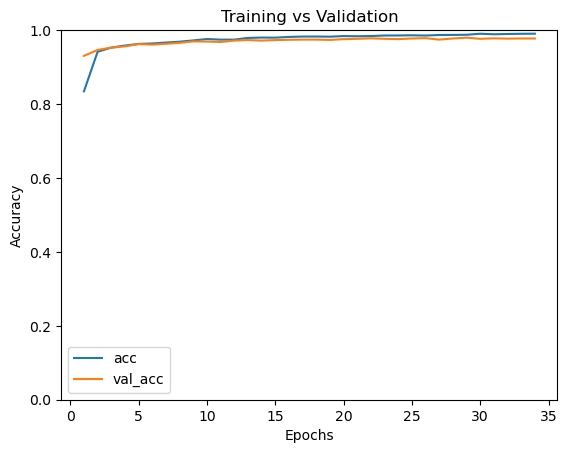

In [18]:
# ===== 7) Plot =====
# acc = history.history.get("accuracy", []); val_acc = history.history.get("val_accuracy", [])
# plt.figure(); plt.plot(range(1,len(acc)+1), acc, label="acc"); plt.plot(range(1,len(val_acc)+1), val_acc, label="val_acc")
# plt.xlabel("Epochs"); plt.ylabel("Accuracy"); plt.legend(); plt.title("Training vs Validation"); plt.show()

acc = history.history.get("accuracy", [])
val_acc = history.history.get("val_accuracy", [])
epochs = range(1, len(acc) + 1)

plt.figure()
plt.plot(epochs, acc, label="acc")
plt.plot(epochs, val_acc, label="val_acc")
plt.ylim(0, 1)                         # 🔁 변경점 4: 축 고정으로 왜곡 방지
plt.xlabel("Epochs"); plt.ylabel("Accuracy")
plt.title("Training vs Validation")
plt.legend(); plt.show()

In [ ]:
# ===== 8) TFLite 변환 =====
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

# TFLite 모델 저장
# Save outputs into the repo-local phishing/ folder
tflite_path = "phishing/phishing_model.tflite"
with open(tflite_path, 'wb') as f:
    f.write(tflite_model)

print(f"TFLite 모델이 저장되었습니다: {tflite_path}")

# 피처 정보 저장 (Android에서 사용)
import json
feature_info = {
    "feature_columns": numeric_cols,
    "input_shape": [X_train.shape[1]],
    "normalization_layer": "norm_all"
}

feature_info_path = "phishing/feature_info.json"
with open(feature_info_path, 'w') as f:
    json.dump(feature_info, f, indent=2)

print(f"피처 정보가 저장되었습니다: {feature_info_path}")

INFO:tensorflow:Assets written to: /var/folders/nv/tfw2zdqs7031dn83bb91bwdr0000gn/T/tmp40jqtk8t/assets


INFO:tensorflow:Assets written to: /var/folders/nv/tfw2zdqs7031dn83bb91bwdr0000gn/T/tmp40jqtk8t/assets


Saved artifact at '/var/folders/nv/tfw2zdqs7031dn83bb91bwdr0000gn/T/tmp40jqtk8t'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 87), dtype=tf.float32, name='features')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  13277553552: TensorSpec(shape=(1, 87), dtype=tf.float32, name=None)
  13277554320: TensorSpec(shape=(1, 87), dtype=tf.float32, name=None)
  13277550864: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13277553744: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13277552976: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13277552400: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13277554512: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13277552784: TensorSpec(shape=(), dtype=tf.resource, name=None)
TFLite 모델이 저장되었습니다: /Users/seungmin/Desktop/승민/대학/YU/3-2/프로젝트/QR/YU_mobile_kotlin/phishing/phishing_model.tflite
피처 정보가 저장되었습니다: /Users/seungmin/Desk

W0000 00:00:1762222936.805347 13337158 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1762222936.805362 13337158 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
2025-11-04 11:22:16.805473: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /var/folders/nv/tfw2zdqs7031dn83bb91bwdr0000gn/T/tmp40jqtk8t
2025-11-04 11:22:16.805787: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2025-11-04 11:22:16.805794: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /var/folders/nv/tfw2zdqs7031dn83bb91bwdr0000gn/T/tmp40jqtk8t
2025-11-04 11:22:16.808336: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2025-11-04 11:22:16.824455: I tensorflow/cc/saved_model/loader.cc:220] Running initialization op on SavedModel bundle at path: /var/folders/nv/tfw2zdqs7031dn83bb91bwdr0000gn/T/tmp40jqtk8t
2025-11-04 11:22:16.829250: I tensorflow/cc/saved_model/loader.c